# pyschedule - resource-constrained scheduling in python

![](https://github.com/timnon/pyschedule/blob/master/pics/gantt.png)

pyschedule is the easiest way to match tasks with resources, period. It covers problems such as flow- and job-shop scheduling, travelling salesman, vehicle routing with time windows, and many more combinations of theses. Install it with pip:

In [ ]:
pip install pyschedule

Here is a hello world example, you can also find this document as a <a href="https://github.com/timnon/pyschedule/blob/master/examples/bike-shop.ipynb">notebook</a> in the <a href="https://github.com/timnon/pyschedule/tree/master/examples">examples folder</a>. For a technical overview go to the <a href="https://github.com/timnon/pyschedule/blob/master/docs/pyschedule-overview.ipynb">overview notebook</a>.

In [39]:
# Load pyschedule and create a scenario with ten steps planning horizon
from pyschedule import Scenario, solvers, plotters
S = Scenario('hello_pyschedule',horizon=10)

# Create two resources
Alice, Bob = S.Resource('Alice'), S.Resource('Bob')

# Create three tasks with lengths 1,2 and 3
cook, wash, clean = S.Task('cook',1), S.Task('wash',2), S.Task('clean',3)

# Assign tasks to resources, either Alice or Bob,
# the %-operator connects tasks and resource
S += cook % Alice|Bob
S += wash % Alice|Bob
S += clean % Alice|Bob

# Solve and print solution
S.use_makespan_objective()
solvers.pulp.solve(S,msg=1)

# Print the solution
print(S.solution())

INFO: execution time for solving mip (sec) = 0.037683725357055664
INFO: objective = 4.0
[(clean, Bob, 0, 3), (cook, Alice, 0, 1), (wash, Alice, 1, 3), (MakeSpan, Alice, 3, 4)]


Here we use a makespan objective which means that we want to minimize the completion time of the last task. Hence, Alice should do the cooking from 0 to 1 and then do the washing from 1 to 3, whereas Bob will only do the cleaning from 0 to 3. This will ensure that both are done after three hours. This table representation is a little hard to read, if you want a visualization, first install matplotlib:


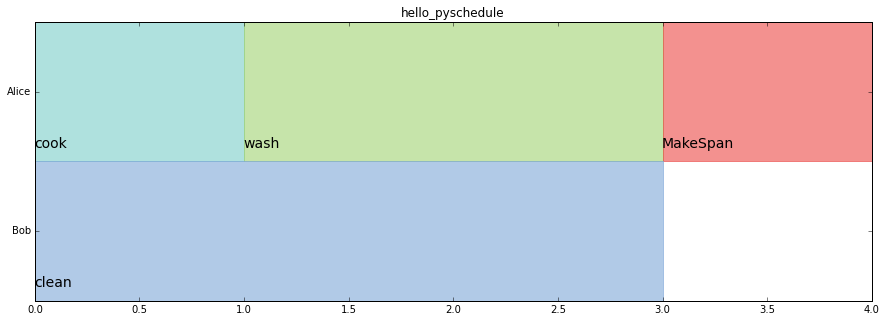

In [40]:
# Plot in the notebook
%matplotlib inline 
plotters.matplotlib.plot(S)

pyschedule supports different solvers, classical <a href="https://en.wikipedia.org/wiki/Integer_programming">MIP</a>-based ones as well as <a href="https://en.wikipedia.org/wiki/Constraint_programming">CP</a>. All solvers and their capabilities are listed in the <a href="https://github.com/timnon/pyschedule/blob/master/docs/pyschedule-overview.ipynb">overview notebook</a>. The default solver used above uses a standard MIP-model in combination with <a href="https://projects.coin-or.org/Cbc">CBC</a>, which is part of package <a href="https://pypi.python.org/pypi/PuLP">pulp</a>. If you have CPLEX installed (command "cplex" must be running), you can easily switch to CPLEX using:


In [ ]:
solvers.pulp.solve(S,kind='CPLEX')

pyschedule is under active development, there might be non-backward-compatible changes

# Alice and Bob optimize their bike paint shop with pyschedule

Alice and Bob are running a paint shop for bikes where they pimp bikes with fresh colors. Today they have to paint a green and a red bike. To get started they import pyschedule and create a new scenario. We use hours as granularity and expect a working day of at most 10 hours, so we set the planning horizon to 10. Some solvers do not need this parameter, but the default solver requires it:

In [42]:
from pyschedule import Scenario, solvers, plotters
S = pyschedule.Scenario('bike_paint_shop', horizon=10)

Then they create themselves as resources:

In [43]:
Alice = S.Resource('Alice')
Bob = S.Resource('Bob')

Painting a bike takes two hours. Moreover, after the bike has been painted, it needs to get post-processed (e.g. tires pumped) which takes one hour (which is the default). This translates into four tasks in total:

In [44]:
green_paint, red_paint = S.Task('green_paint', length=2), S.Task('red_paint', length=2)
green_post, red_post = S.Task('green_post'), S.Task('red_post')

Clearly, one can only do the post-processing after the painting with an arbitrary gap in between. For the red paint we are a little stricter, here we want to start the post-processing exactly one hour after the painting since this is the time the color takes to dry:

In [45]:
S += green_paint < green_post, red_paint + 1 <= red_post

Since they are equally qualified, each task can be done by either Alice or Bob. Note that we use the %-operator to assign resources to tasks:

In [46]:
S += green_paint % Alice|Bob
S += green_post % Alice|Bob

S += red_paint % Alice|Bob
S += red_post % Alice|Bob

So lets have a look at the scenario:

In [47]:
S.clear_solution()
print(S)

###############################################

SCENARIO: bike_paint_shop / horizon: 10

OBJECTIVE: 

RESOURCES:
Alice
Bob

TASKS:
green_paint : [green_paint % Alice|Bob]
red_paint : [red_paint % Alice|Bob]
green_post : [green_post % Alice|Bob]
red_post : [red_post % Alice|Bob]

LAX PRECEDENCES:
green_paint < green_post

TIGHT PRECEDENCES:
red_paint + 1 <= red_post

###############################################


We havent defined an objective yet, lets use the MakeSpan and check the scenario again:

In [48]:
S.use_makespan_objective()
print(S)

###############################################

SCENARIO: bike_paint_shop / horizon: 10

OBJECTIVE: MakeSpan

RESOURCES:
Alice
Bob

TASKS:
green_paint : [green_paint % Alice|Bob]
red_paint : [red_paint % Alice|Bob]
green_post : [green_post % Alice|Bob]
red_post : [red_post % Alice|Bob]
MakeSpan : [MakeSpan % Alice]

LAX PRECEDENCES:
green_paint < green_post
green_paint < MakeSpan
red_paint < MakeSpan
green_post < MakeSpan
red_post < MakeSpan

TIGHT PRECEDENCES:
red_paint + 1 <= red_post

###############################################


Hence, we want to minimize the position of the MakeSpan task subject to the constraint that it is scheduled after all other tasks. Thus, the position of the MakeSpan is the length of our schedule. Now we have the first version of our scenario, lets solve and plot it:

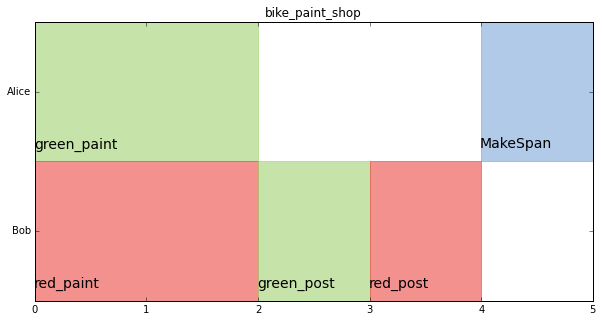

In [49]:
# Set some colors for the tasks
task_colors = { green_paint   : '#A1D372',
                green_post    : '#A1D372', 
                red_paint     : '#EB4845',
                red_post      : '#EB4845',
                S['MakeSpan'] : '#7EA7D8'} # We can get tasks using their name

# A small helper method to solve and plot a scenario
def run(S) :
    S.clear_solution() # Clear already computed solution if existing
    if pyschedule.solvers.pulp.solve(S):
        %matplotlib inline
        pyschedule.plotters.matplotlib.plot(S,task_colors=task_colors,fig_size=(10,5))
    else:
        print('no solution exists')
    
run(S)

Alice is annoyed, if she paints the red bike, she also wants to do the post-processing, switching bikes takes too much time. We use the following constraints to ensure this. They ensure that painting and post-processing the red bike will both be done by either Alice or Bob. The same holds for the green on:

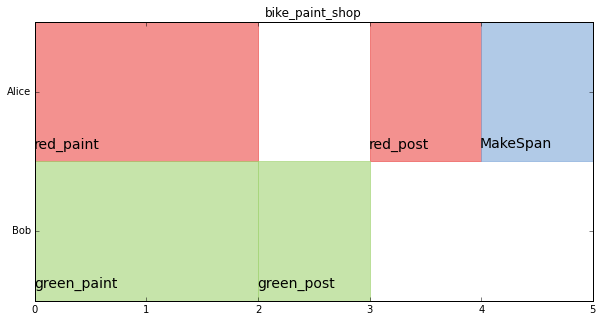

In [50]:
# First remove the old resource to task assignments
S -= green_paint % Alice|Bob
S -= green_post % Alice|Bob
S -= red_paint % Alice|Bob
S -= red_post % Alice|Bob

# Add new ones
S += Alice|Bob % {green_paint, green_post}
S += Alice|Bob % {red_paint, red_post}
run(S)

This schedule completes after four hours and suggests to paint both bikes at the same time. However, Alice and Bob have only a single paint shop which they need to share:

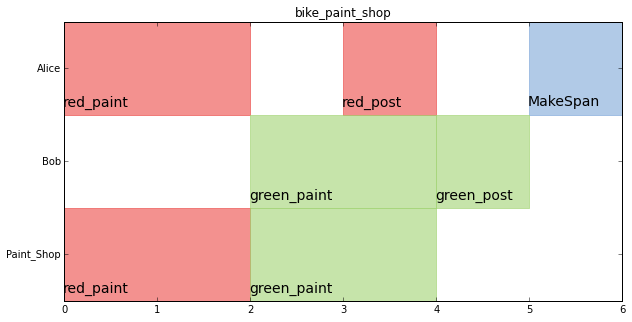

In [51]:
Paint_Shop = S.Resource('Paint_Shop')
S += red_paint % Paint_Shop
S += green_paint % Paint_Shop
run(S)

Great, everybody can still go home after five hours and have a late lunch! Unfortunately, Alice receives a call that the red bike will only arrive after two hours:

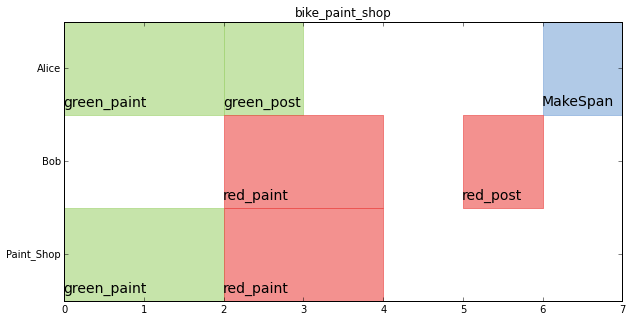

In [52]:
S += red_paint > 2
run(S)

Still everybody can go home after six hours. However, we encounter another problem, it is actually quite hard to switch the paint shop from green to red because the green color is quite sticky, this takes two hours of external cleaning. We model this with the following conditional precedence constraint, which says that there needs to be a break of two hours if the red painting follows the green one:

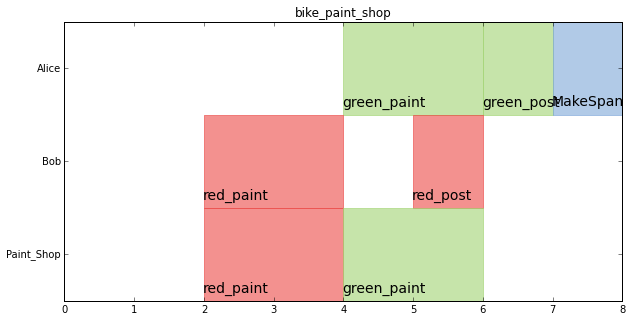

In [53]:
S += green_paint + 2 << red_paint
run(S)

Damn, we have a full day of seven hours, this requires a lunch between the third and the fifth hour:

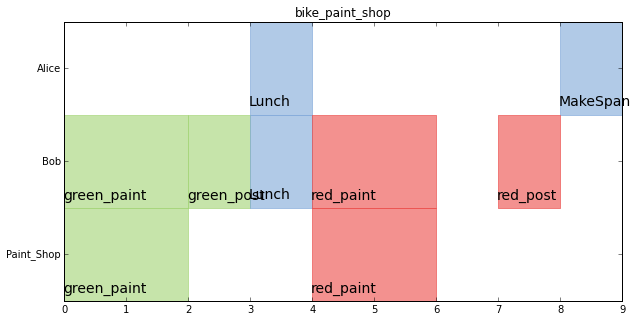

In [54]:
Lunch = S.Task('Lunch')
S += Lunch > 3, Lunch < 5
S += Lunch % {Alice, Bob}
task_colors[Lunch] = '#7EA7D8'
run(S)

Our goal so far is to minimize the MakeSpan, the final completion time of any task. We can also make this more explicit:

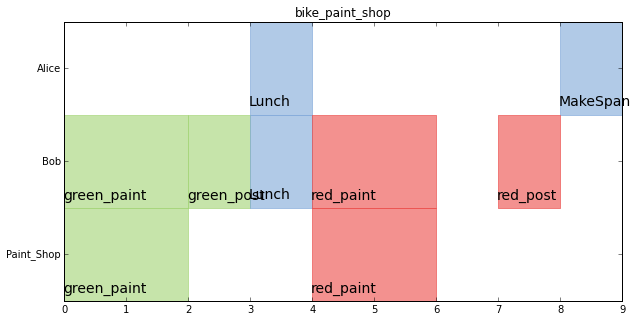

In [55]:
# First we remove the old MakeSpan (and all corresponding constraint)
S -= S['MakeSpan']

# Then we create our own MakeSpan
MakeSpan = S.Task('MakeSpan')
S += MakeSpan % Alice
S += MakeSpan > {green_post,red_post}
S += MakeSpan*1 # add the makespan (*1) to scenario for use as objective
task_colors[MakeSpan] = '#7EA7D8'
run(S)

Unfortunately, Bob needs to do all the work. To evenly distribute the the work, we can assign capacities to resources:

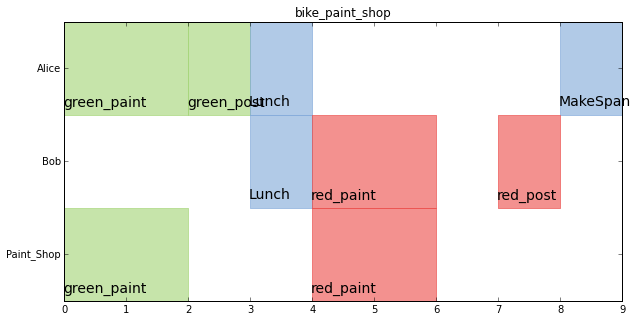

In [56]:
S += Alice['length'] <= 5
S += Bob['length'] <= 5
run(S)

Also Alice wants to definitely do some work before lunch, that is, before the fourth hour:

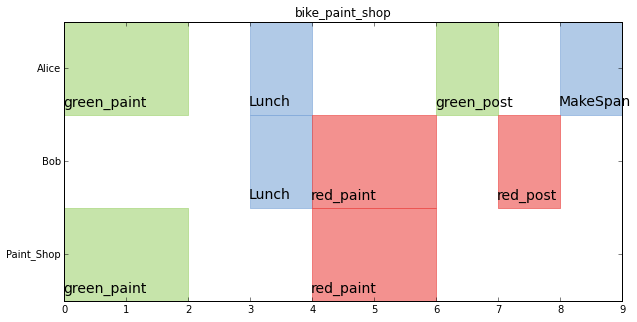

In [57]:
S += Alice['length'][:4] >= 2
run(S)

Finally Bob gets a call from the owner of the red bike which offers to give them a huge tip if they manage to finish his bike as early as possible. After talking with Alice, they give a six times higher priority, which translates into the following flow-time objective:

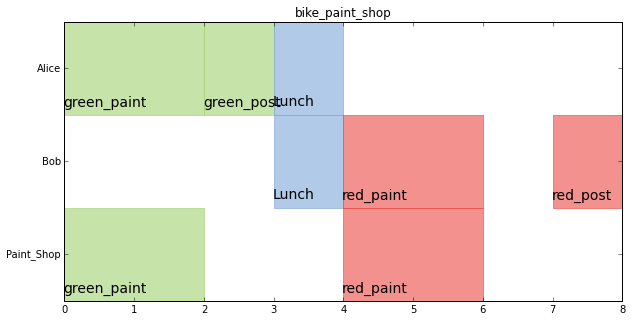

In [58]:
S -= MakeSpan
S += red_post*6 + green_post*1
run(S)

All this sounds quite trivial, but think about the same problem with many bikes and many persons!